In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import catboost
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
#from category_encoders.count import CountEncoder
from sklearn.preprocessing import OneHotEncoder,PowerTransformer, StandardScaler
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate

In [ ]:
#read in data
path = '/content/drive/MyDrive/Colab Notebooks/data_ghls'
df = pd.read_csv(path + '/Train.csv')
test_df = pd.read_csv(path+ '/Test.csv')
print(df.shape)
print(test_df.shape)

(21454, 19)
(7194, 18)


In [ ]:
# Check for exact duplicate rows
duplicate_train = df.duplicated()
duplicate_test = test_df.duplicated()
print(f"Number of  train_duplicate rows: {duplicate_train.sum()}")
print(f"Number of test_duplicate rows: {duplicate_test.sum()}")

Number of  train_duplicate rows: 0
Number of test_duplicate rows: 0


In [ ]:
#check missing values and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ID                                       21454 non-null  object 
 1   country                                  21454 non-null  object 
 2   year                                     21454 non-null  int64  
 3   urban_or_rural                           21454 non-null  object 
 4   ghsl_water_surface                       21454 non-null  float64
 5   ghsl_built_pre_1975                      21454 non-null  float64
 6   ghsl_built_1975_to_1990                  21454 non-null  float64
 7   ghsl_built_1990_to_2000                  21454 non-null  float64
 8   ghsl_built_2000_to_2014                  21454 non-null  float64
 9   ghsl_not_built_up                        21454 non-null  float64
 10  ghsl_pop_density                         21454

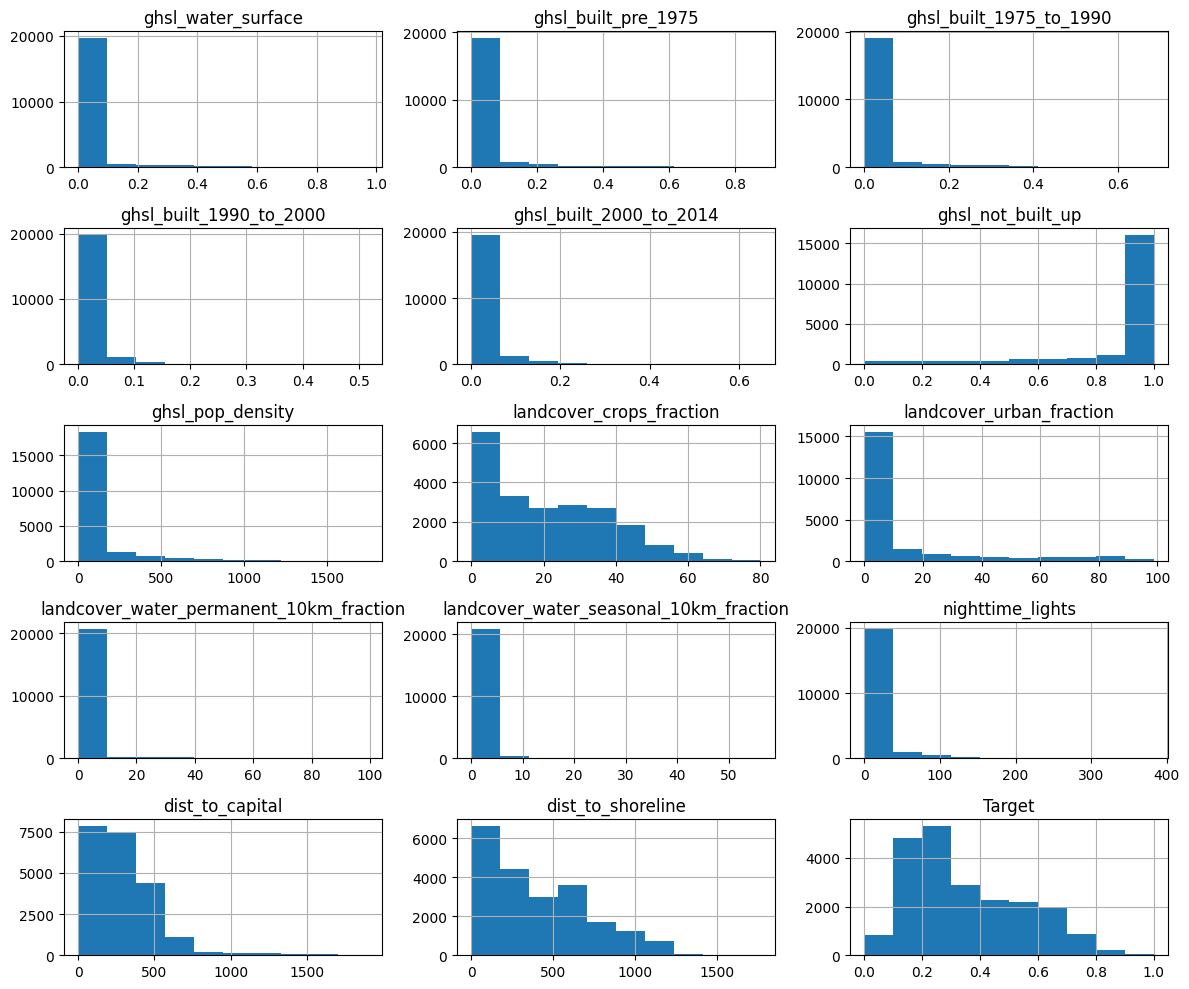

In [ ]:
#distribution of numerical columns
num_cols = df.select_dtypes(include=['float64'])
fig, axs = plt.subplots(5, 3, figsize=(12, 10))
axs = axs.flatten()

for i, col in enumerate(num_cols):
    df[col].hist(ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

In [ ]:
#correlation matrix
data = df.select_dtypes('number')
matrix = data.corr()
fig = px.imshow(matrix,
                text_auto=True,
                color_continuous_scale='RdBu_r',
                title='Correlation Matrix',
                width=800,
                height=800)

fig.update_layout(margin=dict(l=40, r=40, t=40, b=40))
fig.show()

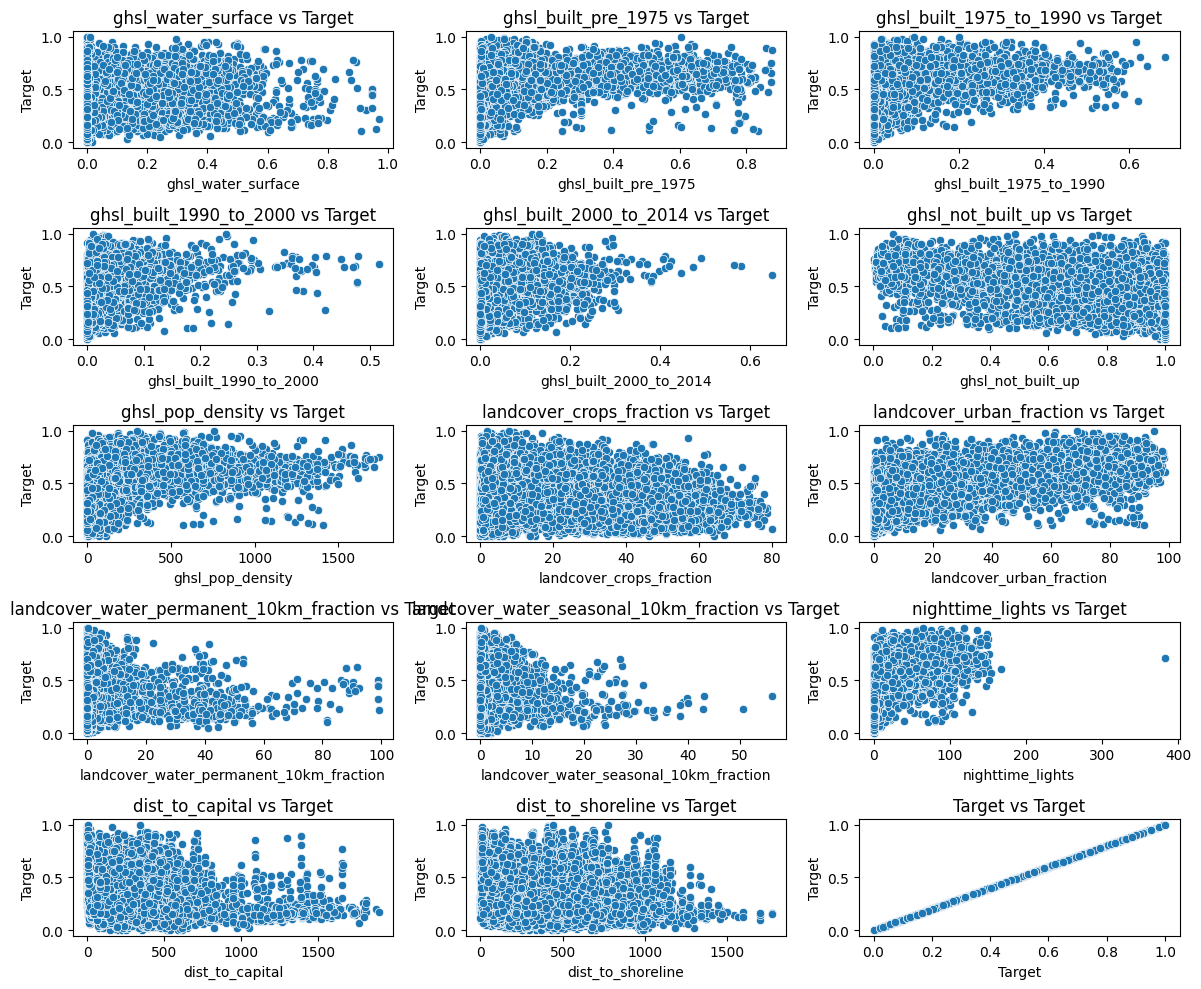

In [ ]:
#target vs numerical columns
fig, axes = plt.subplots(5,3, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols[:5 * 3]):
    sns.scatterplot(x=df[col], y=df['Target'], ax=axes[i])
    axes[i].set_title(f'{col} vs Target')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

feature interactions and engineering

In [ ]:
def add_features(df):
  df['pop_light_interaction'] = df['ghsl_pop_density'] * df['nighttime_lights']
  # Ratio of urban to crop land
  # adding 1e-6 to avoid the zero division error
  df['urban_crop_ratio'] = df['landcover_urban_fraction'] / (df['landcover_crops_fraction'] + 1e-6)
    # Built-up ratio
  built_columns = ['ghsl_built_pre_1975', 'ghsl_built_1975_to_1990',
                    'ghsl_built_1990_to_2000', 'ghsl_built_2000_to_2014']
  df['total_built'] = df[built_columns].sum(axis=1)
  df['builtup_ratio'] = df['total_built'] / (df['ghsl_not_built_up'] + 1e-6)

  # Water balance
  df['seasonal_vs_permanent_water'] = df['landcover_water_seasonal_10km_fraction'] / (
        df['landcover_water_permanent_10km_fraction'] + 1e-6)
  return df

In [ ]:
#map countries to region. taking into account the new countries in test data
region_map = {
    # East Africa
    'Ethiopia': 'East Africa',
    'Kenya': 'East Africa',
    'Tanzania': 'East Africa',
    'Rwanda': 'East Africa',
    'Uganda':'East Africa',

    # West Africa
    'Ghana': 'West Africa',
    'Nigeria': 'West Africa',
    'Senegal': 'West Africa',
    'Mali': 'West Africa',
    'Guinea': 'West Africa',
    'Sierra Leone': 'West Africa',
    "Cote d'Ivoire": 'West Africa',
    'Togo': 'West Africa',
    'Burkina Faso': 'West Africa',
    'Benin': 'West Africa',

    # Central Africa
    'Cameroon': 'Central Africa',
    'Central African Republic': 'Central Africa',
    'Democratic Republic of Congo':'Central Africa',
    'Angola':'Central Africa',

    # Southern Africa
    'Mozambique': 'Southern Africa',
    'Malawi': 'Southern Africa',
    'Swaziland': 'Southern Africa',
    'Lesotho': 'Southern Africa',
    'Zambia':'Southern Africa',
    'Zimbabwe':'Southern Africa'
}
# bin year
def bin_year_custom(year):
    if year < 2000:
        return 'pre-2000'
    elif 2000 <= year <= 2009:
        return '2000s'
    elif 2010 <= year <= 2019:
        return '2010s'
    else:
        return 'other'
#region map
df['region'] = df['country'].map(region_map)
#bin year
df['year_group'] = df['year'].apply(bin_year_custom)

In [ ]:
# standardising data so that it is similar across models even for catboost that requires less preprocessing
#split into features and target
X = df.drop(columns=['ID','Target'], axis =1)
y = df[['Target']]
#encode data
num_cols = X.select_dtypes(include='float64',exclude=['int64','object']).columns
cat_cols = X.select_dtypes('object').columns
# Define preprocessors
num_transformer = Pipeline([
    ('power', PowerTransformer()),
    ('scaler', StandardScaler())])

cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)])

pipeline building

In [ ]:
# Random forest pipeline
pipe_forest = Pipeline([
        ('preprocessor', preprocessor),
        ('lr_model', RandomForestRegressor(random_state= 42))
    ])
#fit model
cv_results = cross_validate(pipe_forest, X,y,n_jobs=-1,
                                scoring= ('r2','neg_root_mean_squared_error'),
                                return_train_score= True)
# print results
eval_metrics = ['test_r2', 'train_r2', 'test_neg_root_mean_squared_error', 'train_neg_root_mean_squared_error']
print("RandomForestRegressor scores;")
for metric in eval_metrics:
    if metric in cv_results.keys():
        mean_score = cv_results[metric].mean()
        print(f'{metric}: {round(mean_score,3)}')

RandomForestRegressor scores;
test_r2: 0.779
train_r2: 0.968
test_neg_root_mean_squared_error: -0.091
train_neg_root_mean_squared_error: -0.035


In [ ]:
# Gradient boosting Regression pipeline
pipe_gb = Pipeline([
        ('preprocessor', preprocessor),
        ('lr_model', GradientBoostingRegressor(random_state= 42))
    ])
#fit model
cv_results = cross_validate(pipe_gb, X,y,n_jobs=-1,
                                scoring= ('r2','neg_root_mean_squared_error'),
                                return_train_score= True)
# print results
eval_metrics = ['test_r2', 'train_r2', 'test_neg_root_mean_squared_error', 'train_neg_root_mean_squared_error']
print("GradientBoostingRegressor scores;")
for metric in eval_metrics:
    if metric in cv_results.keys():
        mean_score = cv_results[metric].mean()
        print(f'{metric}: {round(mean_score,3)}')

GradientBoostingRegressor scores;
test_r2: 0.771
train_r2: 0.782
test_neg_root_mean_squared_error: -0.093
train_neg_root_mean_squared_error: -0.091


In [ ]:
# Gradient boosting Regression pipeline
pipe_cbr = Pipeline([
        ('preprocessor', preprocessor),
        ('lr_model', CatBoostRegressor(depth = 8,
                                       iterations =2000,
                                       l2_leaf_reg = 9,
                                       learning_rate = 0.03,
                                       verbose =0))
    ])
#fit model
cv_results = cross_validate(pipe_cbr, X,y,n_jobs=-1,
                                scoring= ('r2','neg_root_mean_squared_error'),
                                return_train_score= True)
# print results
eval_metrics = ['test_r2', 'train_r2', 'test_neg_root_mean_squared_error', 'train_neg_root_mean_squared_error']
print(" CatBoostRegressor scores;")
for metric in eval_metrics:
    if metric in cv_results.keys():
        mean_score = cv_results[metric].mean()
        print(f'{metric}: {round(mean_score,3)}')

 CatBoostRegressor scores;
test_r2: 0.795
train_r2: 0.878
test_neg_root_mean_squared_error: -0.088
train_neg_root_mean_squared_error: -0.068


hyperparameter tuning

In [ ]:
pipe_cbr = Pipeline([
        ('preprocessor', preprocessor),
        ('lr_model', CatBoostRegressor())
    ])
param_grid = {'lr_model__iterations': [500, 1000, 2000],
              'lr_model__learning_rate': [0.01, 0.03, 0.1],
              'lr_model__depth': [4, 6, 8, 10],
               'lr_model__l2_leaf_reg': [1, 3, 5, 9],}
grid = GridSearchCV(estimator = pipe_cbr,
                    param_grid = param_grid,
                    scoring = 'neg_root_mean_squared_error',
                    cv =3,
                    n_jobs =-1,
                    verbose = 0)
grid.fit(X,y)
print("Best parameters: {}".format(grid.best_params_))
print("Best cross-validation: {:.4f}".format(-grid.best_score_))

0:	learn: 0.1905305	total: 72.3ms	remaining: 2m 24s
1:	learn: 0.1868056	total: 95.4ms	remaining: 1m 35s
2:	learn: 0.1832448	total: 115ms	remaining: 1m 16s
3:	learn: 0.1797549	total: 133ms	remaining: 1m 6s
4:	learn: 0.1765373	total: 153ms	remaining: 1m 1s
5:	learn: 0.1734290	total: 173ms	remaining: 57.4s
6:	learn: 0.1704111	total: 191ms	remaining: 54.4s
7:	learn: 0.1675151	total: 210ms	remaining: 52.4s
8:	learn: 0.1646244	total: 229ms	remaining: 50.8s
9:	learn: 0.1618586	total: 249ms	remaining: 49.6s
10:	learn: 0.1591597	total: 268ms	remaining: 48.5s
11:	learn: 0.1566028	total: 293ms	remaining: 48.6s
12:	learn: 0.1541192	total: 313ms	remaining: 47.8s
13:	learn: 0.1517675	total: 332ms	remaining: 47.1s
14:	learn: 0.1494105	total: 351ms	remaining: 46.4s
15:	learn: 0.1473280	total: 370ms	remaining: 45.9s
16:	learn: 0.1452105	total: 389ms	remaining: 45.4s
17:	learn: 0.1432329	total: 408ms	remaining: 44.9s
18:	learn: 0.1412837	total: 429ms	remaining: 44.7s
19:	learn: 0.1394399	total: 448ms	re

In [ ]:
cat_features = ['country', 'urban_or_rural', 'region', 'year_group']
model = CatBoostRegressor(verbose= 0).fit(X,y,cat_features= cat_features)
#get feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=True)
#plot
fig = px.bar(data_frame=feature_importance_df, x='Importance', y ='Feature', title= 'Catboost Feature Importance')
fig.show()

predictions and submissions

In [ ]:
#read in in test_df
test_df.head(2)

,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline
0,ID_AAcismbB,Democratic Republic of Congo,2007,R,0.0,0.000000,0.000000,0.000523,0.000131,0.999347,0.660758,0.990942,0.132264,0.069055,0.032627,0.0,1249.294720,1364.592100
1,ID_AAeBMsji,Democratic Republic of Congo,2007,U,0.0,0.004239,0.000238,0.001227,0.002860,0.991437,6.441547,5.461365,0.452400,0.000000,0.000000,0.0,821.019579,1046.028681


In [ ]:
X_test = add_features(test_df)
X_test['region'] = X_test['country'].map(region_map)
#bin year
X_test['year_group'] = X_test['year'].apply(bin_year_custom)
X_test.columns

Index(['ID', 'country', 'year', 'urban_or_rural', 'ghsl_water_surface',
       'ghsl_built_pre_1975', 'ghsl_built_1975_to_1990',
       'ghsl_built_1990_to_2000', 'ghsl_built_2000_to_2014',
       'ghsl_not_built_up', 'ghsl_pop_density', 'landcover_crops_fraction',
       'landcover_urban_fraction', 'landcover_water_permanent_10km_fraction',
       'landcover_water_seasonal_10km_fraction', 'nighttime_lights',
       'dist_to_capital', 'dist_to_shoreline', 'pop_light_interaction',
       'urban_crop_ratio', 'total_built', 'builtup_ratio',
       'seasonal_vs_permanent_water'],
      dtype='object')

In [ ]:
X_test['region'] = X_test['country'].map(region_map)
#bin year
X_test['year_group'] = X_test['year'].apply(bin_year_custom)
X_test.columns

Index(['ID', 'country', 'year', 'urban_or_rural', 'ghsl_water_surface',
       'ghsl_built_pre_1975', 'ghsl_built_1975_to_1990',
       'ghsl_built_1990_to_2000', 'ghsl_built_2000_to_2014',
       'ghsl_not_built_up', 'ghsl_pop_density', 'landcover_crops_fraction',
       'landcover_urban_fraction', 'landcover_water_permanent_10km_fraction',
       'landcover_water_seasonal_10km_fraction', 'nighttime_lights',
       'dist_to_capital', 'dist_to_shoreline', 'pop_light_interaction',
       'urban_crop_ratio', 'total_built', 'builtup_ratio',
       'seasonal_vs_permanent_water', 'region', 'year_group'],
      dtype='object')

In [ ]:
X_test = X_test.drop('ID', axis = 1)
X_test.shape

(7194, 24)

In [ ]:
X.shape

(21454, 24)

In [ ]:
cat_features = ['country', 'urban_or_rural', 'region', 'year_group']
model = CatBoostRegressor(depth = 8,
                          iterations =2000,
                          l2_leaf_reg = 9,
                          learning_rate = 0.03,
                          verbose =0).fit(X,y,cat_features= cat_features)
#predict
y_pred = model.predict(X_test)
test_submission = pd.DataFrame({'ID':test_df.ID,
                                'Target': y_pred})
test_submission.head()

,ID,Target
0,ID_AAcismbB,0.170079
1,ID_AAeBMsji,0.252352
2,ID_AAjFMjzy,0.607442
3,ID_AAmMOEEC,0.406933
4,ID_ABguzDxp,0.265261


In [ ]:
test_submission.to_csv('test_submission.csv', index = False)